# Financiera Compartamos
-----------------------------------------

In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./lib/")
# for graphics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lib.FuncionesGenerales import Builder

# import data
diccionario = {
    'codigoCredito': str,
    'codigoCliente': str,
    'codigoOficina': str
}

dfCompleto = pd.read_excel('data/dataFinal.xlsx', dtype=diccionario)
dfSegmentacion = pd.read_csv('data/Segmentacion.csv')
ibuilder = Builder(dfCompleto)
respaldo = dfCompleto.copy()

## Exploración de Datos

In [2]:
dfCompleto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29731 entries, 0 to 29730
Data columns (total 15 columns):
codigoCredito       29731 non-null object
codigoCliente       29731 non-null object
codigoOficina       29731 non-null object
tipoCredito         29731 non-null object
moneda              29731 non-null object
sector              29731 non-null object
destinoCredito      29731 non-null object
fechaAperturaMin    29731 non-null datetime64[ns]
fechaAperturaMax    29731 non-null datetime64[ns]
montoApertura       29731 non-null float64
numeroCuotas        29731 non-null int64
montoCancelado      29731 non-null float64
interes             29731 non-null float64
condicionCredito    29731 non-null object
esDeudor            29731 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(2), object(8)
memory usage: 3.4+ MB


In [3]:
dfCompleto.head(3)

,codigoCredito,codigoCliente,codigoOficina,tipoCredito,moneda,sector,destinoCredito,fechaAperturaMin,fechaAperturaMax,montoApertura,numeroCuotas,montoCancelado,interes,condicionCredito,esDeudor
0,001710000017,0140149899,001,RECUPERADO ...,SOLES ...,PEQUEÑAS EMPRESAS ...,CAPITAL DE TRABAJO INFORMAL ...,2017-08-07,2017-08-07,2500.0,12,2151.83,674.10,CASTIGADO (V) ...,1
1,001710000066,0140188681,001,RECURRENTE ...,SOLES ...,PEQUEÑAS EMPRESAS ...,ACTIVO FIJO INFORMAL ...,2017-04-03,2017-08-07,10000.0,24,9376.37,2286.73,CASTIGADO (V) ...,1
2,001710000090,0260173521,001,RECURRENTE ...,SOLES ...,MICROEMPRESA ...,ACTIVO FIJO INFORMAL ...,2017-08-07,2017-08-07,1058.5,12,748.80,284.31,CASTIGADO (V) ...,1


### Trabajando con los datos cualitativos

In [4]:
dfCompleto.describe(include=['object'])

,codigoCredito,codigoCliente,codigoOficina,tipoCredito,moneda,sector,destinoCredito,condicionCredito
count,29731,29731,29731,29731,29731,29731,29731,29731
unique,29731,27506,9,6,1,4,7,5
top,005710148684,0120038344,005,RECURRENTE,SOLES ...,MICROEMPRESA ...,ACTIVO FIJO INFORMAL ...,NORMAL ...
freq,1,3,4949,13648,29731,18148,15423,26494


_Establecer como index a codigoCredito y cambiar codigoCliente a flag cuenta única_

In [5]:
dftest = dfCompleto['codigoCredito'].groupby([dfCompleto['codigoCliente']]).count()
md1c = dftest.index[dftest==1]
dfCompleto['cuentaUnica']=dfCompleto.codigoCliente.isin(md1c) #1 si es unica, 0 si tiene mas de una cuenta
dfCompleto.cuentaUnica=dfCompleto.cuentaUnica.apply(int)
dfCompleto.drop(['codigoCliente'], axis=1, inplace=True)
dfCompleto = dfCompleto.set_index('codigoCredito')

_Analizamos la distribución de los datos cualitativos_

In [6]:
display(pd.value_counts(dfCompleto.codigoOficina))
display(pd.value_counts(dfCompleto.tipoCredito))
display(pd.value_counts(dfCompleto.moneda))
display(pd.value_counts(dfCompleto.sector))
display(pd.value_counts(dfCompleto.destinoCredito))
display(pd.value_counts(dfCompleto.condicionCredito))

005    4949
036    4585
012    4011
007    3969
001    2771
008    2743
038    2557
035    2470
018    1676
Name: codigoOficina, dtype: int64

RECURRENTE                                                                13648
RECUPERADO                                                                 5684
NUEVO                                                                      4020
RECURRENTE                                                                 3560
NUEVO                                                                      1462
RECUPERADO                                                                 1357
Name: tipoCredito, dtype: int64

SOLES                                                                     29731
Name: moneda, dtype: int64

MICROEMPRESA                                                              18148
PEQUEÑAS EMPRESAS                                                          7643
CONSUMO NO REVOLVENTE                                                      3932
MEDIANAS EMPRESAS                                                             8
Name: sector, dtype: int64

ACTIVO FIJO INFORMAL                                                      15423
CAPITAL DE TRABAJO INFORMAL                                                8782
CONSUMO                                                                    3932
CAPITAL DE TRABAJO FORMAL                                                   849
ACTIVO FIJO FORMAL                                                          742
MIXTO INFORMAL                                                                2
VIVIENDA                                                                      1
Name: destinoCredito, dtype: int64

NORMAL                                                                    26494
CASTIGADO (V)                                                              1524
VENCIDO                                                                    1037
VENCIDO +120 DIAS                                                           614
JUDICIAL                                                                     62
Name: condicionCredito, dtype: int64

#### Se realizarán los siguientes cambios:
- __codigoOficina:__ Se podría agrupar por distritos, ciudades pero no se tiene información, no se modificará.
- __tipoCredito:__ Se repiten los campos que son lo mismo, se limpiará los espacios.
- __moneda:__ Se retira este campo por no ser de influencia
- __sector:__ Se juntará MEDIANAS EMPRESAS y PEQUEÑAS EMPRESAS como PYMES debido a su distribución
- __destinoCredito:__ Se retira vivienda, por no ser afín de las categorías y se retiran mixto informal pues hay trabajo y activo se mantendrán separados.
- __condicionCredito:__ La condicion es posterior al prestamo, se evaluará

In [7]:
dfCompleto['tipoCredito'] = dfCompleto.tipoCredito.apply(lambda x: x.replace(" ",""))
dfCompleto.drop(['moneda'], axis=1, inplace=True)
dfCompleto['sector'] = dfCompleto.sector.apply(lambda x: x.replace(" ",""))
dfCompleto.sector.replace(to_replace=dict(MEDIANASEMPRESAS='PYMES', PEQUEÑASEMPRESAS='PYMES', CONSUMONOREVOLVENTE='CONSUMO'), inplace=True)
dfCompleto['destinoCredito'] = dfCompleto.destinoCredito.apply(lambda x: x.replace(" ",""))
dfCompleto = dfCompleto[dfCompleto.destinoCredito != 'MIXTOINFORMAL']
dfCompleto = dfCompleto[dfCompleto.destinoCredito != 'VIVIENDA']
dfCompleto.destinoCredito.replace(to_replace=dict(ACTIVOFIJOINFORMAL='AFINFORMAL',
                          CAPITALDETRABAJOINFORMAL='CTINFORMAL', CAPITALDETRABAJOFORMAL='CTFORMAL', ACTIVOFIJOFORMAL='AFFORMAL'), inplace=True)
dfCompleto['condicionCredito'] = dfCompleto.condicionCredito.apply(lambda x: x.replace(" ",""))
dfCompleto.describe(include=['object'])

,codigoOficina,tipoCredito,sector,destinoCredito,condicionCredito
count,29728,29728,29728,29728,29728
unique,9,3,3,5,5
top,005,RECURRENTE,MICROEMPRESA,ACTIVOFIJOINFORMAL,NORMAL
freq,4948,17205,18147,15423,26492


__Generando los Dummy Variables__

In [8]:
dfRespaldo = dfCompleto.copy()
dummy_codigoOficina = pd.get_dummies(dfCompleto.codigoOficina, prefix="of")
dummy_tipoCredito = pd.get_dummies(dfCompleto.tipoCredito)
dummy_sector = pd.get_dummies(dfCompleto.sector)
dummy_destinoCredito = pd.get_dummies(dfCompleto.destinoCredito)
dummy_condicionCredito = pd.get_dummies(dfCompleto.condicionCredito)

### Datos Cuantitativos

In [9]:
dfCompleto.describe(include=['int64', 'float'])

,montoApertura,numeroCuotas,montoCancelado,interes,esDeudor,cuentaUnica
count,29728.000000,29728.000000,29728.000000,29728.000000,29728.000000,29728.000000
mean,12263.696145,16.458759,7898.627448,3212.341154,0.214545,0.853034
std,15977.355891,7.940662,12057.044968,4337.829264,0.410513,0.354078
min,500.000000,1.000000,0.050000,56.120000,0.000000,0.000000
25%,2078.000000,12.000000,1031.370000,583.237500,0.000000,1.000000
50%,5058.500000,12.000000,2823.400000,1327.195000,0.000000,1.000000
75%,15000.000000,18.000000,8967.087500,3879.530000,0.000000,1.000000
max,150000.000000,72.000000,121922.710000,62201.960000,1.000000,1.000000


__Datos binarios__

In [10]:
display(pd.value_counts(dfCompleto.esDeudor))
display(pd.value_counts(dfCompleto.cuentaUnica))

0    23350
1     6378
Name: esDeudor, dtype: int64

1    25359
0     4369
Name: cuentaUnica, dtype: int64

_montoCancelado se retirará debiado a que no es un dato que se considere al generar un crédito, evaluaremos las distribuciones de los demás campos respecto a si es deudor o no_

<IPython.core.display.Javascript object>


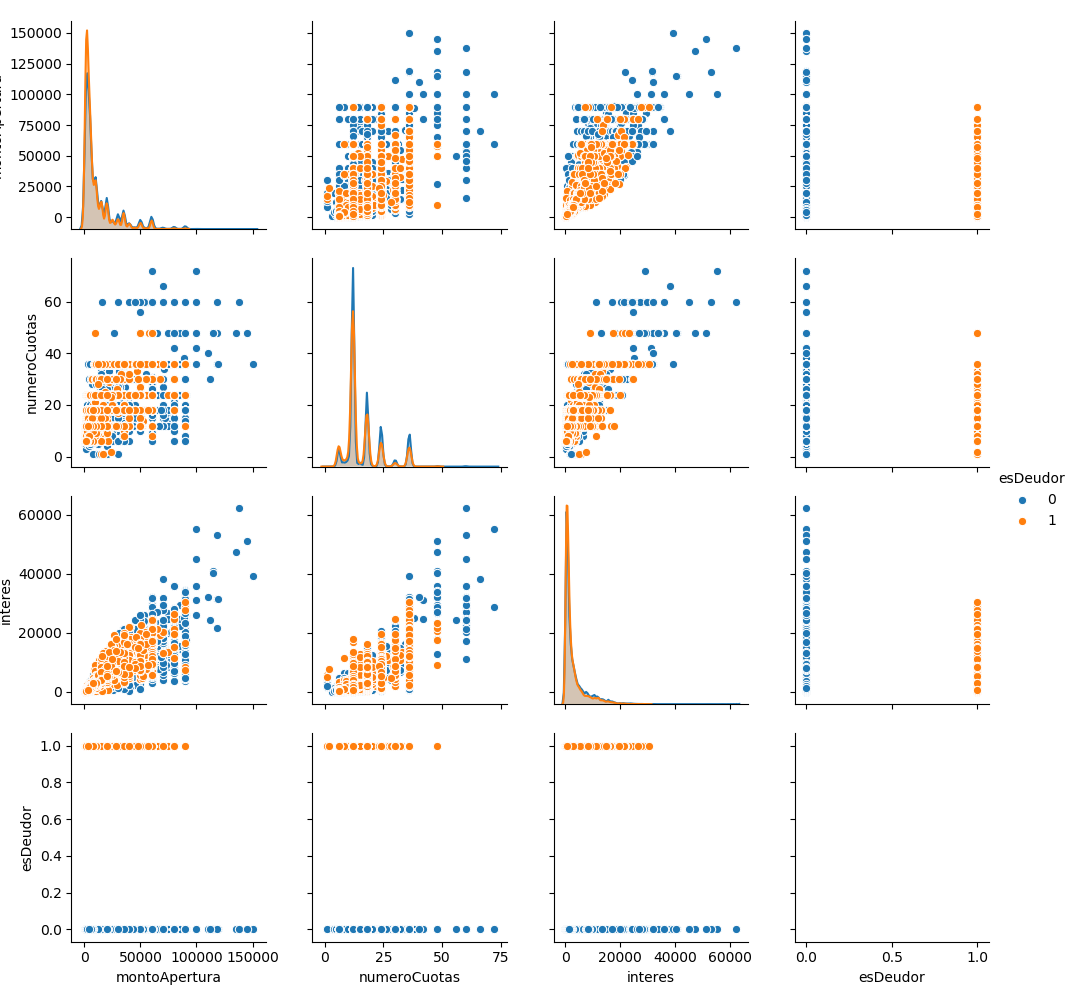

In [13]:
%matplotlib notebook
dfCompleto.drop(['montoCancelado'], axis=1, inplace=True)
sns.pairplot(dfCompleto[['montoApertura', 'numeroCuotas', 'interes', 'esDeudor']], hue="esDeudor")

_Cambiando numeroCuotas a categorico periodos_

<IPython.core.display.Javascript object>


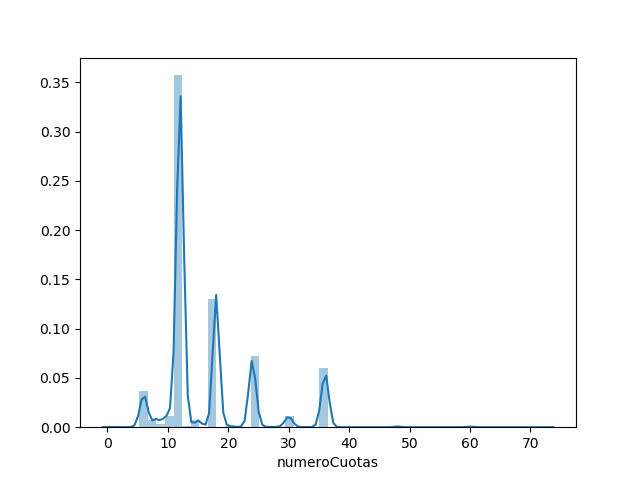

sem2     16015
sem3      5875
sem4      3127
sem6      2544
sem1      1558
sem5       541
sem7+       68
Name: periodos, dtype: int64

In [71]:
sns.distplot(dfCompleto['numeroCuotas'])
dfCompleto['periodos'] = np.int32(np.ceil(dfCompleto.numeroCuotas/6))
dfCompleto['periodos'] = dfCompleto['periodos'].apply(lambda x: x if x < 7 else 9)
dfCompleto.periodos = dfCompleto.periodos.apply(str)
dfCompleto['periodos'] = dfCompleto.periodos.apply(lambda x: "sem"+str(x))
dfCompleto.periodos.replace(to_replace=dict(sem9 = 'sem7+'), inplace=True)
display(pd.value_counts(dfCompleto.periodos))

__Segmentando__

<IPython.core.display.Javascript object>


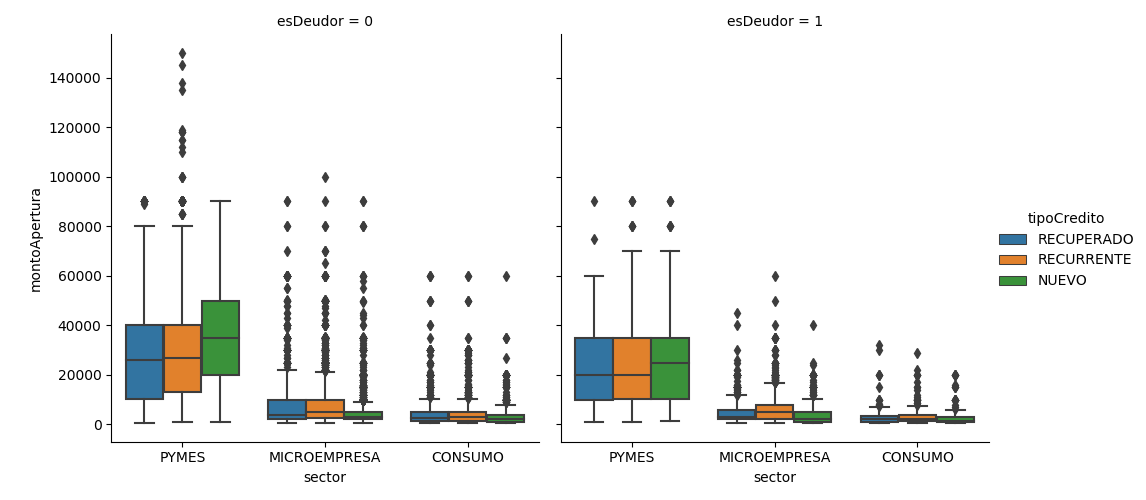

In [84]:
g = sns.catplot(x="sector", y="montoApertura", hue="tipoCredito", col="esDeudor", data=dfCompleto, kind="box")

### Correlación entre los Datos

<IPython.core.display.Javascript object>


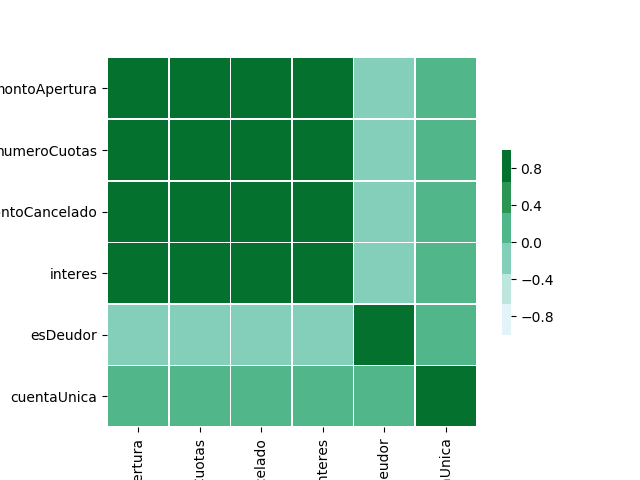

In [85]:
#import matplotlib.pyplot as plt
#sns.set(style="white")
corr = dfCompleto.corr()
f, ax = plt.subplots()
cmap = sns.color_palette("BuGn")
sns.heatmap(corr, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Informal    0.710004
Hogar       0.224376
Formal      0.065620
Name: destinoCredito, dtype: float64

<IPython.core.display.Javascript object>


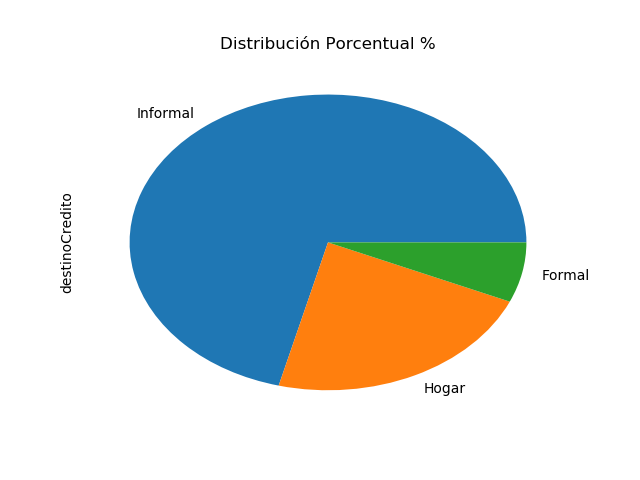

In [35]:
%matplotlib notebook
dist = pd.value_counts(dfGraphics.destinoCredito)/len(dfGraphics.destinoCredito)
display(dist)
(dist).plot(kind='pie', title='Distribución Porcentual %')

### Influencia del Interes

<IPython.core.display.Javascript object>


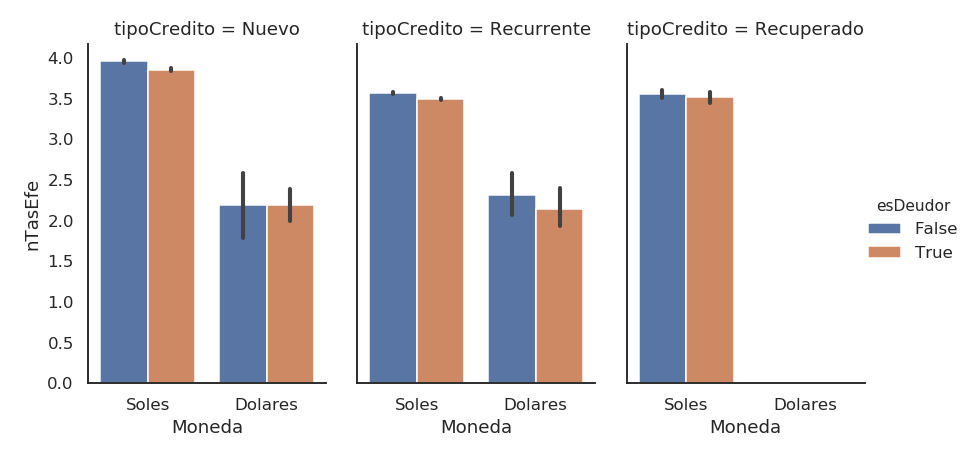

In [31]:
g = sns.catplot(x="Moneda", y="nTasEfe",
                 hue="esDeudor", col="tipoCredito",
                 data=dfGraphics, kind="bar",
                 height=4, aspect=.7)
plt.show()

### Distribución de Deudores según montoApertura y capitalPagado

Deudor


<IPython.core.display.Javascript object>


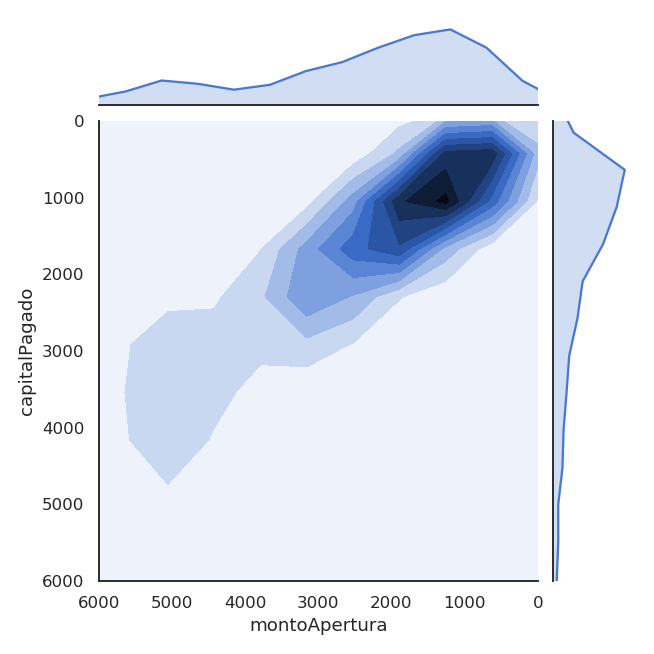

No Deudor


<IPython.core.display.Javascript object>


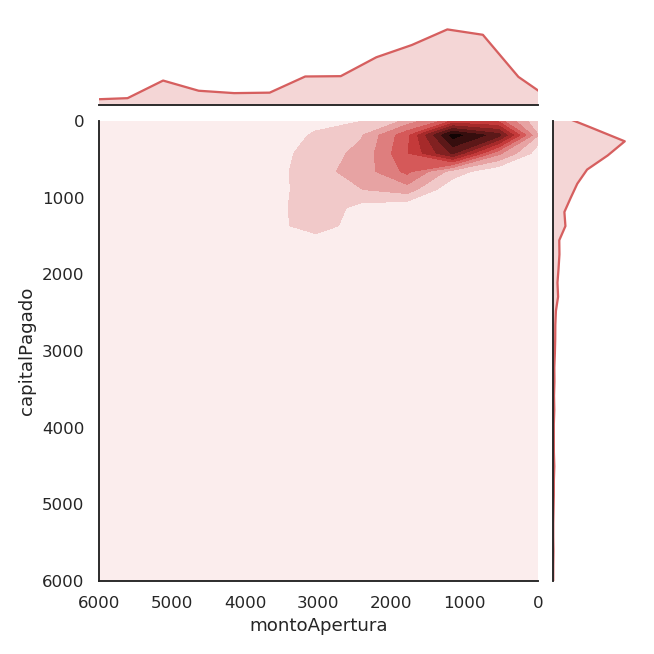

In [130]:
dfDeudor = df.loc[df['esDeudor'] == 'True']
dfNoDeudor = df.loc[df['esDeudor'] == 'False']
print('Deudor')
sns.jointplot(dfDeudor.montoApertura, dfDeudor.capitalPagado, data=dfDeudor, kind="kde", 
              xlim=6000, ylim=6000, color="b");
print('No Deudor')
sns.jointplot(x="montoApertura", y="capitalPagado", data=dfNoDeudor, kind="kde", 
              xlim=6000, ylim=6000, color="r");
plt.show()

### Boxplot para Deudores, según tipoCredito,tipoPersona y destinoCredito

<IPython.core.display.Javascript object>


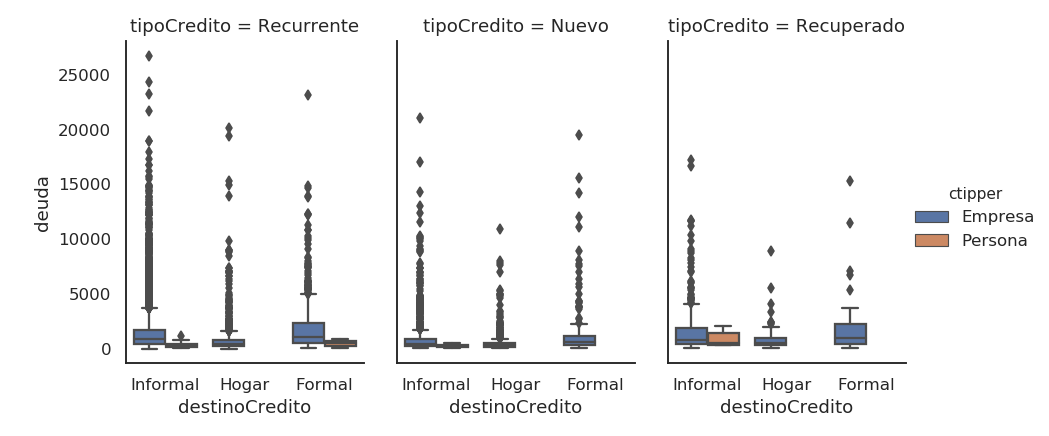

In [59]:
dfDeudor.tipoCredito.replace(['N', 'R', 'U'], ['Nuevo', 'Recurrente', 'Recuperado'], inplace=True)
dfDeudor.destinoCredito.replace(['1', '2', '3', '4', '5', '6', '7', '8'], 
        ['Formal', 'Informal', 'Formal', 'Informal', 'Formal', 'Informal', 'Hogar', 'Hogar'], inplace=True)
dfDeudor.ctipper.replace(['1', '2'], ['Persona', 'Empresa'], inplace=True)
dfDeudor['deuda'] = dfDeudor.montoApertura-dfDeudor.capitalPagado
g = sns.catplot(x="destinoCredito", y="deuda",
                 hue="ctipper", col="tipoCredito",
                 data=dfDeudor, kind="box",
                 height=4, aspect=.7)
plt.show()

### Boxplot para No Deudores, según tipoCredito,tipoPersona y destinoCredito

<IPython.core.display.Javascript object>


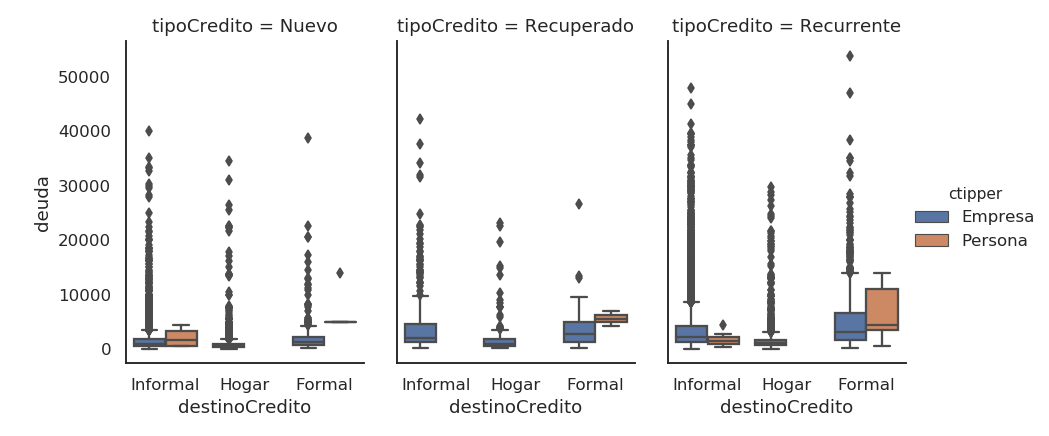

In [61]:
dfNoDeudor.tipoCredito.replace(['N', 'R', 'U'], ['Nuevo', 'Recurrente', 'Recuperado'], inplace=True)
dfNoDeudor.destinoCredito.replace(['1', '2', '3', '4', '5', '6', '7', '8'], 
        ['Formal', 'Informal', 'Formal', 'Informal', 'Formal', 'Informal', 'Hogar', 'Hogar'], inplace=True)
dfNoDeudor.ctipper.replace(['1', '2'], ['Persona', 'Empresa'], inplace=True)
dfNoDeudor['deuda'] = dfNoDeudor.montoApertura-dfNoDeudor.capitalPagado
g = sns.catplot(x="destinoCredito", y="deuda",
                 hue="ctipper", col="tipoCredito",
                 data=dfNoDeudor, kind="box",
                 height=4, aspect=.7)
plt.show()

### Comparativa del marco Judicial sobre las Personas

Deudores


<IPython.core.display.Javascript object>


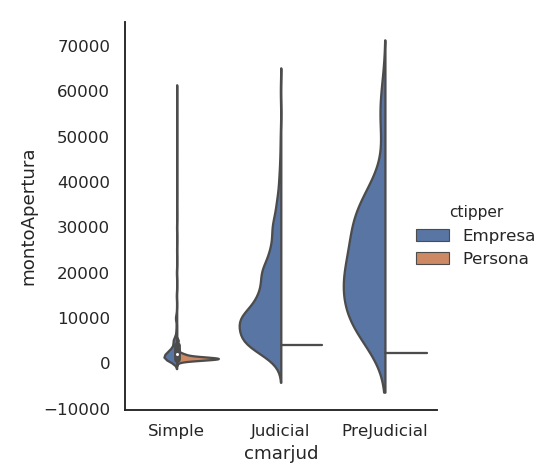

No Deudores


<IPython.core.display.Javascript object>


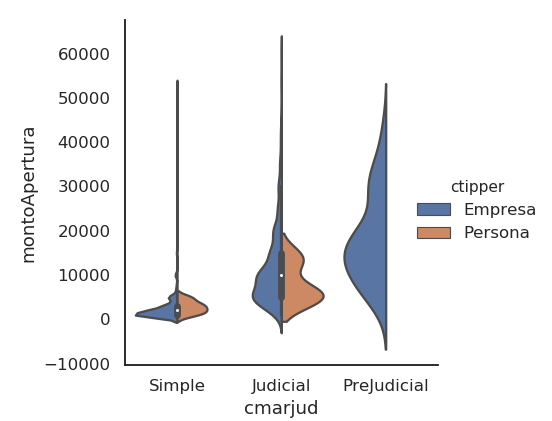

In [89]:
dfDeudor.cmarjud.replace(['J', 'P', 'S'], ['Judicial', 'PreJudicial', 'Simple'], inplace=True)
dfNoDeudor.cmarjud.replace(['J', 'P', 'S'], ['Judicial', 'PreJudicial', 'Simple'], inplace=True)
print('Deudores')
sns.catplot(x="cmarjud", y="montoApertura", hue="ctipper", kind="violin", split=True, data=dfDeudor);
print('No Deudores')
sns.catplot(x="cmarjud", y="montoApertura", hue="ctipper", kind="violin", split=True, data=dfNoDeudor);
plt.show()

<IPython.core.display.Javascript object>


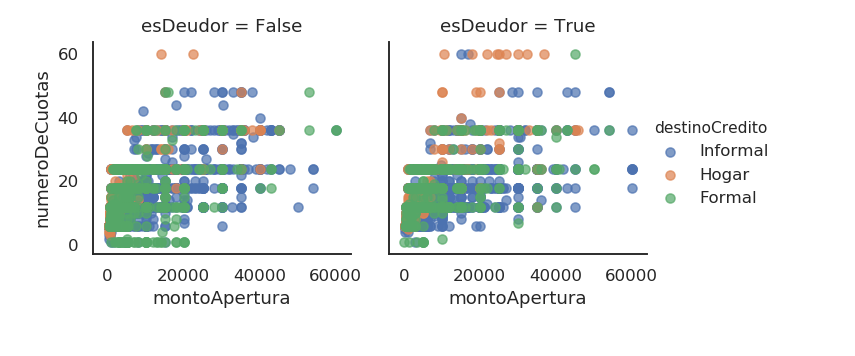

In [91]:
g = sns.FacetGrid(dfGraphics, col="esDeudor", hue="destinoCredito")
g.map(plt.scatter, "montoApertura", "numeroDeCuotas", alpha=.7)
g.add_legend();

<IPython.core.display.Javascript object>


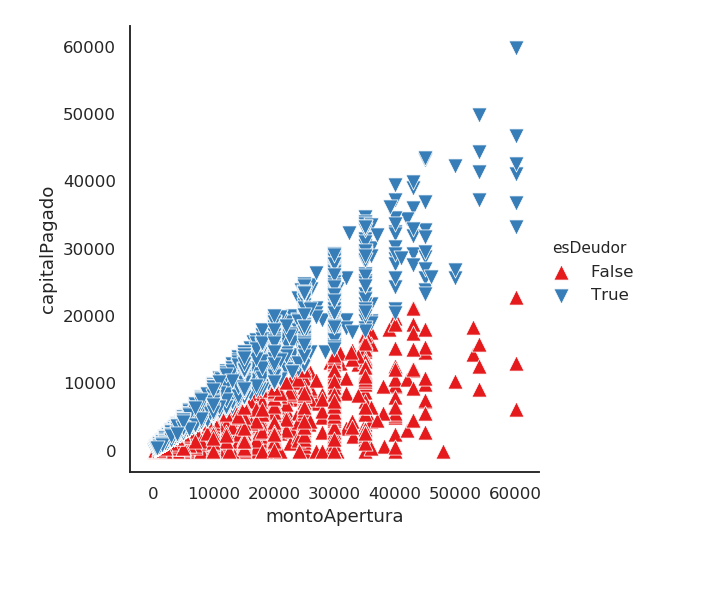

In [111]:
g = sns.FacetGrid(dfGraphics, hue="esDeudor", palette="Set1", height=5, hue_kws={"marker": ["^", "v"]})
g.map(plt.scatter, "montoApertura", "capitalPagado", s=100, linewidth=.5, edgecolor="white")
g.add_legend();
plt.show()

# Predicción y Evaluación del Modelo

In [21]:
dfTrain = df.copy()
dfTrain['tcNuevo']=(dfTrain.tipoCredito=='N').astype(int)
dfTrain['tcRecurrente']=(dfTrain.tipoCredito=='R').astype(int)
dfTrain['monedaSol']=(dfTrain.Moneda=='1').astype(int)
dfTrain['modCredito']=(dfTrain.modalidadCredito=='1').astype(int)
dfTrain['modOrdinario']=(dfTrain.modalidadCredito=='3').astype(int)
dfTrain['seBajo']=(dfTrain.sectorEconomico.isin(['01','02','03'])).astype(int)
dfTrain['seMedio']=(dfTrain.sectorEconomico.isin(['04','05'])).astype(int)
dfTrain['dcFormal']=(dfTrain.destinoCredito.isin(['1','3','5'])).astype(int)
dfTrain['dcInformal']=(dfTrain.destinoCredito.isin(['2','4','6'])).astype(int)
dfTrain['esPersona']=(dfTrain.ctipper=='1').astype(int)
dfTrain['esExponencial']=(dfTrain.ctipcal=='E').astype(int)
dfTrain['esCondJudicial']=(dfTrain.condicionCredito=='J').astype(int)
dfTrain['marcoJudicial']=(dfTrain.cmarjud=='J').astype(int)
dfTrain['marcoPreJudicial']=(dfTrain.cmarjud=='P').astype(int)
#display(dfTrain.cCodOfi.unique())
dfTrain['cuentaUnica']=(dfTrain.cuentaUnica=='1').astype(int)
dfTrain['clienteMoroso']=(dfTrain.clienteMoroso=='1').astype(int)
dfTrain.drop(['tipoCredito', 'Moneda', 'sectorEconomico', 'condicionCredito', 
    'modalidadCredito', 'destinoCredito', 'ctipper', 'ctipcal', 'cmarjud'], axis=1, inplace=True)
dfTrain.esDeudor.replace(['True', 'False'], ['Si', 'No'], inplace=True)

__Guardar los Datos Filtrados__

In [95]:
writer = pd.ExcelWriter('dataFiltrada.xlsx')
dfTrain.to_excel(writer,'Hoja1')
writer.save()

__Dividimos la Data aleatoriamente en 80% para entrenar y 20% para evaluar__

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
seed = 100
X = dfTrain.drop(['esDeudor'], axis=1, inplace=False)
y = dfTrain.esDeudor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [23]:
clf = DecisionTreeClassifier(random_state=seed)
precision = cross_val_score(clf, X, y, cv=10)
display(precision)

array([ 0.99867286,  0.99635036,  0.99900431,  0.99900431,  0.99701294,
        1.        ,  0.99933599,  0.99634794,  0.99800797,  0.99833997])

## Entrenamiento y Predición con el modelo de Arbol de Clasificación

In [160]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [24]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusión Normalizada")
    else:
        print('Matriz de Confusión, sin normalizar')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Predicho')

Matriz de Confusión, sin normalizar
[[4229    4]
 [   6 3293]]


<IPython.core.display.Javascript object>


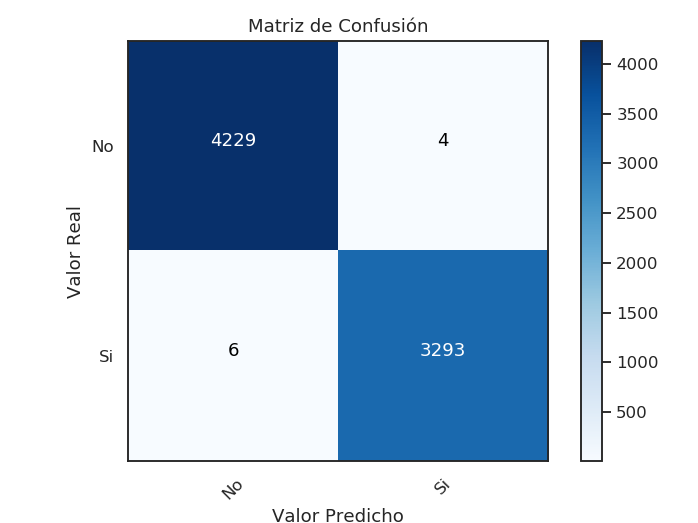

In [162]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=y.unique(), #normalize=True,
                      title='Matriz de Confusión')
plt.show()

In [169]:
p_no_deudor = 3293/(6+3293)*100
p_deudor = 4229/(4+4229)*100
display('Probabilidad de identificar a cliente NO DEUDOR',p_no_deudor)
display('Probabilidad de identificar a cliente DEUDOR',p_deudor)

'Probabilidad de identificar a cliente NO DEUDOR'

99.81812670506214

'Probabilidad de identificar a cliente DEUDOR'

99.90550437042288

## Segunda Prueba, quitando las columnas correlacionadas a esDeudor

In [25]:
X = dfTrain.drop(['esDeudor', 'capitalPagado', 'numeroCuotasPagadas'], axis=1, inplace=False)
y = dfTrain.esDeudor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
clf = DecisionTreeClassifier(random_state=seed)
precision = cross_val_score(clf, X, y, cv=10)
display(precision)

array([ 0.78069011,  0.79927007,  0.81314305,  0.8300697 ,  0.81480252,
        0.84102224,  0.83997344,  0.83598938,  0.82403718,  0.8247012 ])

Matriz de Confusión, sin normalizar
[[4352  746]
 [ 789 3152]]


<IPython.core.display.Javascript object>


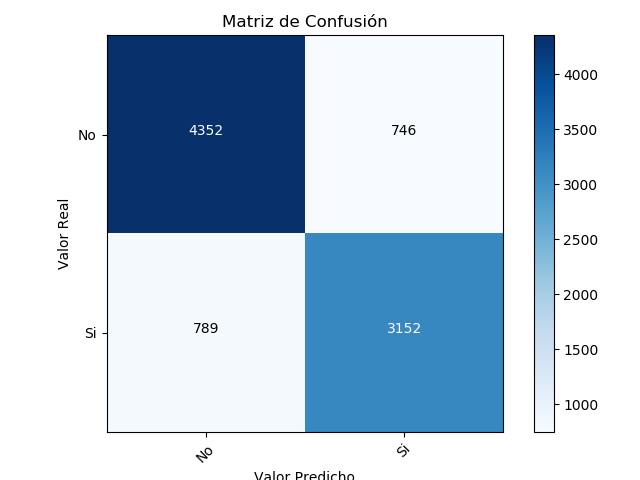

In [26]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=y.unique(), #normalize=True,
                      title='Matriz de Confusión')
plt.show()

In [170]:
p_no_deudor = 3152/(789+3152)*100
p_deudor = 4352/(746+4352)*100
display('Probabilidad de identificar a cliente NO DEUDOR',p_no_deudor)
display('Probabilidad de identificar a cliente DEUDOR',p_deudor)

'Probabilidad de identificar a cliente NO DEUDOR'

79.97970058360822

'Probabilidad de identificar a cliente DEUDOR'

85.36681051392702

In [31]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())
graph.write_svg('tree.svg')

True